## <center> House Price - Best Approach Taken

In [1]:
#Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, ElasticNet
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p

#Handle warnings
import warnings
warnings.filterwarnings('ignore')

#Set precision to 4 decimals
%precision 4

'%.4f'

In [2]:
#Read dataset
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
#Review train data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#Review test data
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#Review shape of dataset
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

## Backup the original data as we might mess it up in the process

In [6]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

#### Different ways to find Numerical and Categorical columns

In [7]:
catg_feats = df_train.select_dtypes(include='object').columns #Replace include by exclude for numerical features
catg_feats1 = df_train.dtypes[df_train.dtypes == 'object'].index #Change == by != for numerical features
catg_feats == catg_feats1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

## Outliers

<li>By definition, an outlier is something that is outside of the expected response. How far you're willing to consider something to be an outlier, is down to the individual and the problem.
<li>From this definition, this outlier will therefore sit way outside of the distribution of data points. Hence, this will skew the distribution of the data and potential calculations.
    <br>
    <img src='img/OutliersImpact.png'>

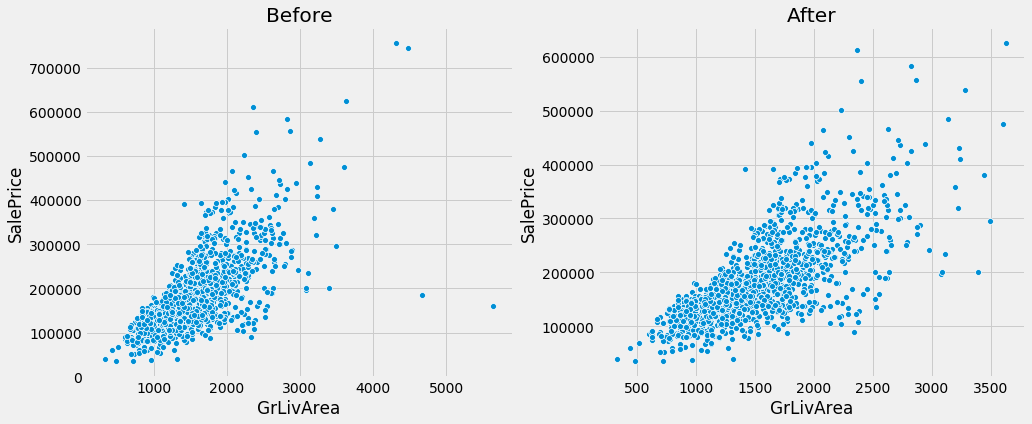

In [88]:
#Plotting with and without outliers
plt.subplots(figsize=(15,6))

#Subplot 1
plt.subplot(1, 2, 1) #1row 2cols 1st Graph
sb.scatterplot(df_train.GrLivArea, df_train.SalePrice).set_title('Before');

#Subplot 2
plt.subplot(1, 2, 2) #1row 2col 2nd Graph
df_temp = df_train.drop(df_train[df_train.GrLivArea>4000].index, axis=0)
sb.scatterplot(df_temp.GrLivArea, df_temp.SalePrice).set_title('After');

## Types of Relationship between two variables: <br>
<img src='img/typesofgraph.png'>

### Find Null Values

In [8]:
def FindNulls(df_temp):
    noofrows = df_temp.shape[0]
    totalnas = df_temp.isnull().sum().sort_values(ascending=False)
    percent = round(df_temp.isnull().sum().sort_values(ascending=False)/noofrows*100,2)
    return pd.concat([totalnas, percent], keys=['Totalnas','Percentage'], axis=1)

df_temp = FindNulls(df_train)
df_temp.head()

,Totalnas,Percentage
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26


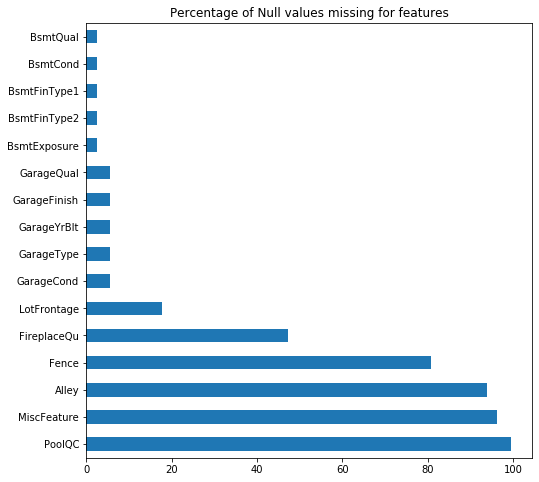

In [9]:
plt.figure(figsize=(8,8))
df_temp[df_temp['Percentage']>1]['Percentage'].plot(kind='barh')
plt.title('Percentage of Null values missing for features')
plt.show();

In [80]:
# c['SaleType']=c['SaleType'].fillna(method='ffill') ##Impute na by forward fill method

#### Drop null values when it is greater than 90%

In [11]:
df_temp = df_train.dropna(thresh = len(df_train)*0.9, axis=1)
print('No. of Columns dropped:', df_train.shape[1] - df_temp.shape[1])
print('Dropped Cols:', [col for col in df_train.columns if col not in df_temp.columns])

No. of Columns dropped: 6
Dropped Cols: ['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


## Imputer

In [ ]:
# # from sklearn.impute import SimpleImputer
# # num_im = SimpleImputer(missing_values=np.nan, strategy='mean')
# # cat_im = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# #Handle numerical nulls
# training_data[num_feats] =  num_im.fit_transform(training_data[num_feats])

# #Handle Categorical nulls
# training_data[catg_feats] = cat_im.fit_transform(training_data[catg_feats])

## Different Visualizations

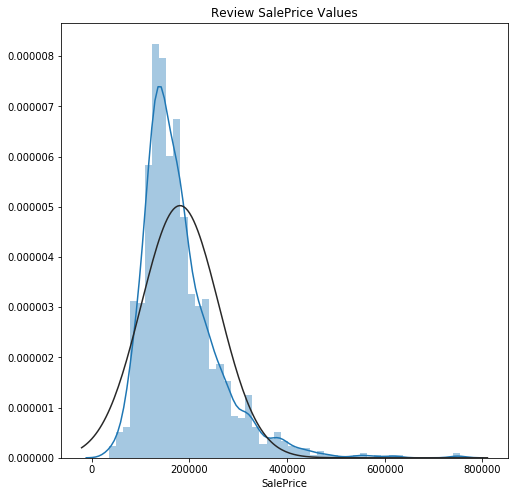

In [12]:
#Plot target variable
plt.figure(figsize=(8,8))
sb.distplot(df_train['SalePrice'], fit=norm)
plt.title('Review SalePrice Values')
plt.show();

### Probability Plot

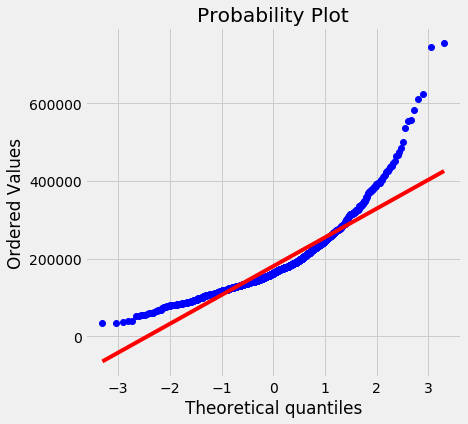

In [44]:
#Probability Plot
plt.figure(figsize=(6,6))
stats.probplot(df_train['SalePrice'], plot=plt)
plt.show();

### Plotting three graphs on Target variable for better review

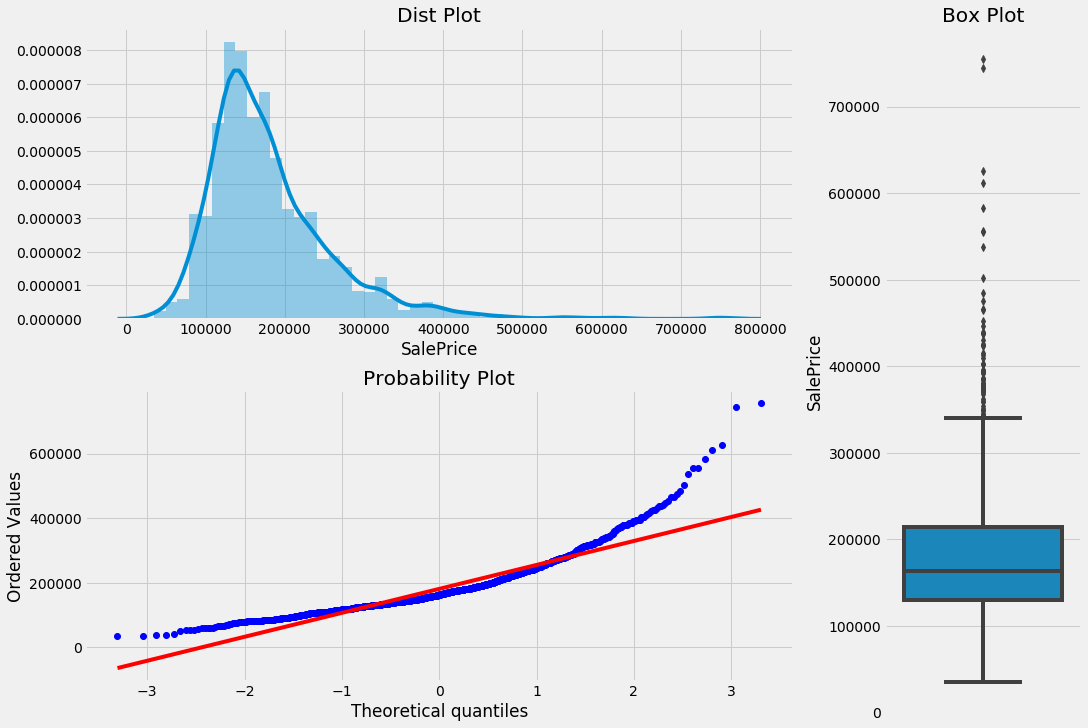

In [61]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import style, gridspec
from scipy import stats

#Set style for Graph
style.use('fivethirtyeight')

#Define Chart Layout
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

#Define subplots
grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

#Assign and draw graph 1
ax1 = fig.add_subplot(grid[0,:2])
#Set title
ax1.set_title('Dist Plot')
#Draw Graph
sb.distplot(df_train.SalePrice, norm_hist=True, ax=ax1);

#Assign and draw graph 2
ax2 = fig.add_subplot(grid[1,:2])

#Set Graph2 title
ax2.set_title('Probability Plot')

#Draw Graph 2
stats.probplot(df_train.SalePrice, plot=ax2);

#Assign and draw graph 3
ax3 = fig.add_subplot(grid[:,2])

#Set title for graph 3
ax3.set_title('Box Plot')

#Draw Graph3
sb.boxplot(df_train.SalePrice, orient='v', ax=ax3);

In [14]:
print('Skewness of Target Variable:', df_train['SalePrice'].skew())
print('Kurtosis of Target Variable:', df_train['SalePrice'].kurt())

Skewness of Target Variable: 1.8828757597682129
Kurtosis of Target Variable: 6.536281860064529


#### Skewness

is the degree of distortion from the symmetrical bell curve or the normal curve.
So, a symmetrical distribution will have a skewness of "0".
<br>
<li> There are two types of Skewness: Positive and Negative.
<li> Positive Skewness(similar to our target variable distribution) means the tail on the right side of the distribution is longer and fatter.
<li> In positive Skewness the mean and median will be greater than the mode. This is similar to this dataset. So, in Layman's terms, more houses were sold by less than the average price.
<li> Negative Skewness means the tail on the left side of the distribution is longer and fatter.
<li> In negative Skewness the mean and median will be less than the mode.
<li>Skewness differentiates extreme values in one versus the other tail.
<img src=img/Skewness.jpeg>
    
#### Kurtosis

It is the measure of the extreme values(outliers) present in the distribution.
<br>
<li>There are three types of Kurtosis: Mesokurtic, Leptokurtic and Platykurtic.
<li>Mesokurtic is similar to normal curve with the standard value of 3. This means that the extreme values of this distrubution is similar to that of a normal distribution.
<li>Leptokurtic Example of leptokurtic distributions are the T-distributions with small degrees of freedom.
<li>Platykurtic: Platykurtic describes a particular statistical distribution with thinner tails than a normal distribution. Because this distribution has thin tails, it has fewer outliers (e.g., extreme values three or more standard deviations from the mean) than do mesokurtic and leptokurtic distributions.
<img src=img/KurtosisPict.jpg
    
Credits - https://www.kaggle.com/masumrumi/a-detailed-regression-guide-with-house-pricing

## Subplots

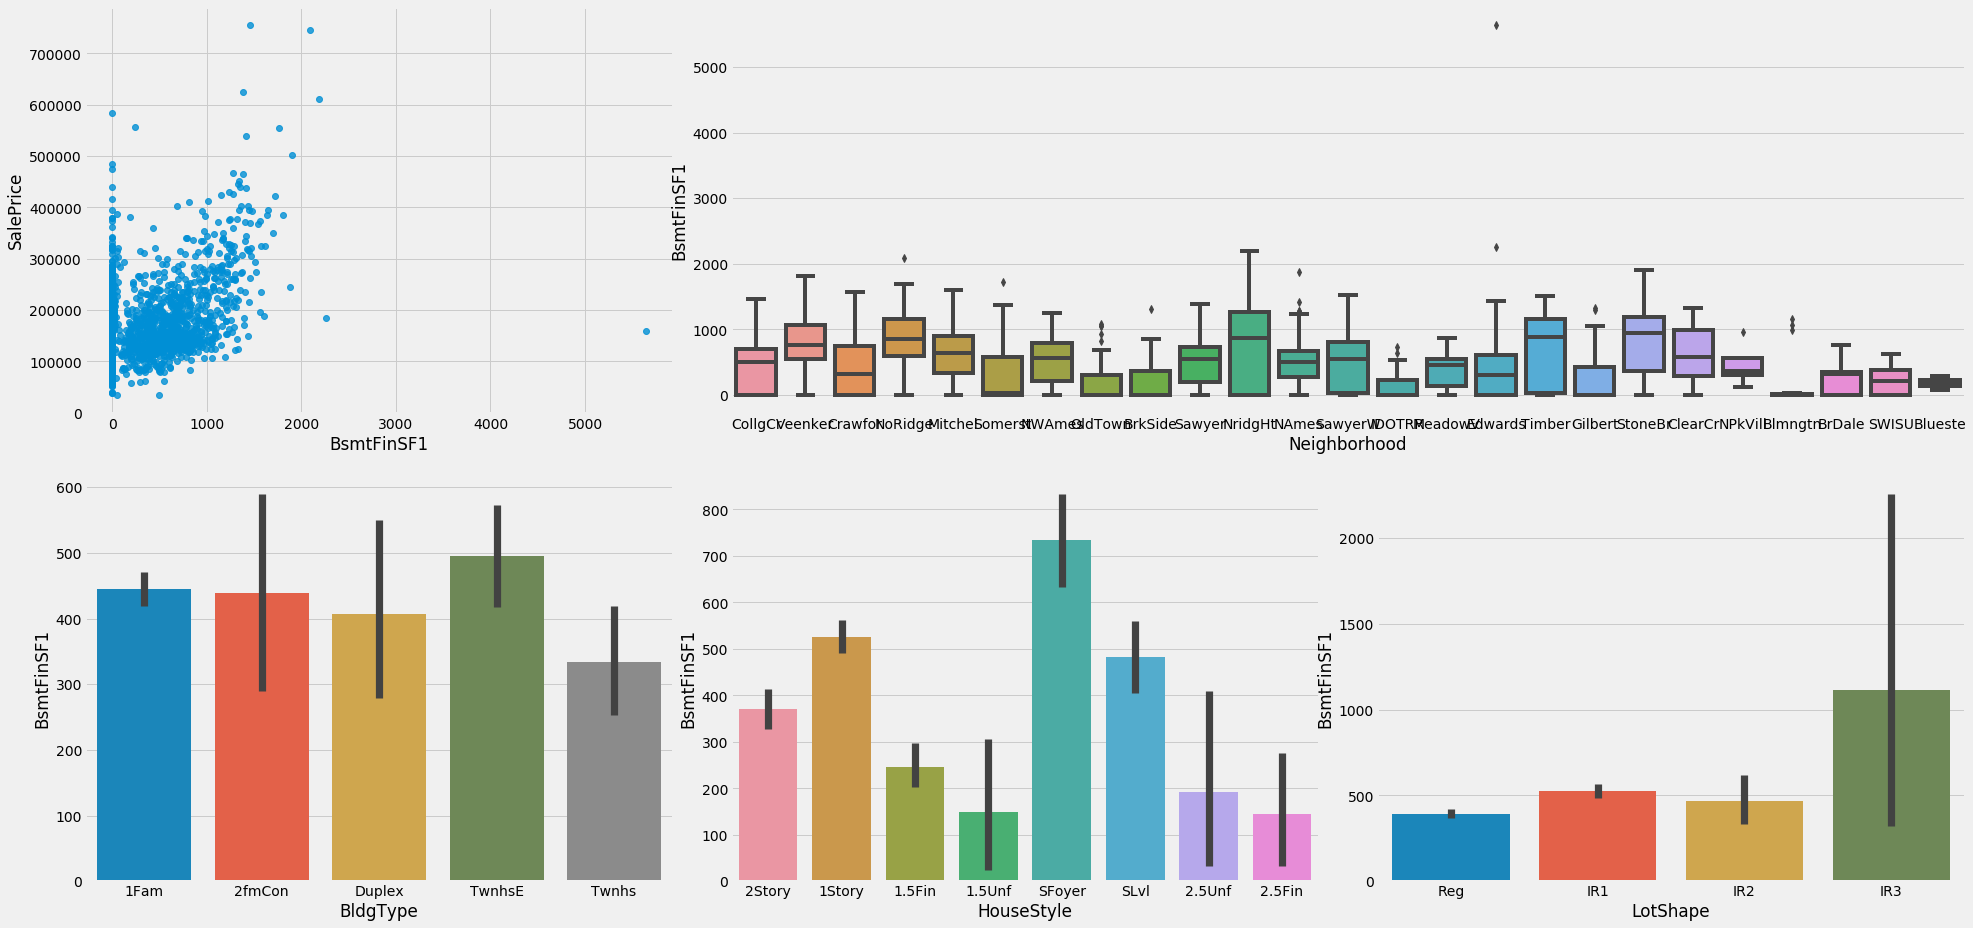

In [96]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize=(30, 15))

#Plot1
plt.subplot(grid[0, 0])
sb.regplot(df_train.BsmtFinSF1, df_train.SalePrice, fit_reg=False, label='RegPlot')

#Plot2
plt.subplot(grid[0,1:])
sb.boxplot(df_train.Neighborhood, df_train.BsmtFinSF1)

#Plot3
plt.subplot(grid[1,0])
sb.barplot(df_train.BldgType, df_train.BsmtFinSF1)

#Plot4
plt.subplot(grid[1,1])
sb.barplot(df_train.HouseStyle, df_train.BsmtFinSF1)

#Plot5
plt.subplot(grid[1,2])
sb.barplot(df_train.LotShape, df_train.BsmtFinSF1);

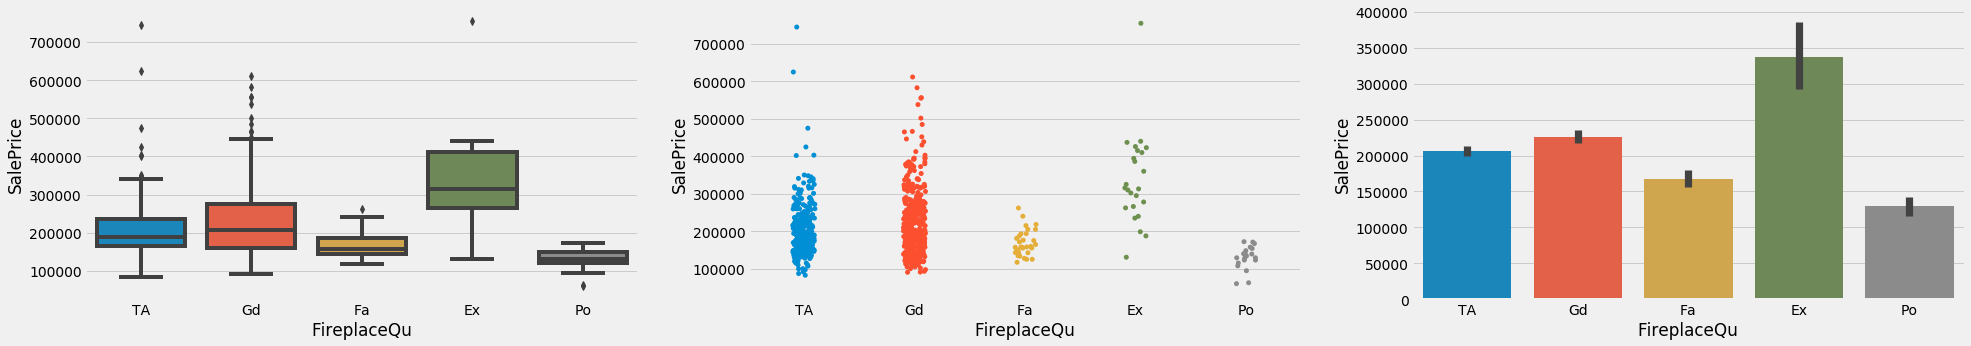

In [102]:
#Subplots
plt.subplots(figsize=(30, 5))

#Plot1
plt.subplot(1, 3, 1)
sb.boxplot(df_train.FireplaceQu, df_train.SalePrice)

#Plot2
plt.subplot(1, 3, 2)
sb.stripplot(df_train.FireplaceQu, df_train.SalePrice, size=5, jitter=True)

#Plot3
plt.subplot(1, 3, 3)
sb.barplot(df_train.FireplaceQu, df_train.SalePrice);

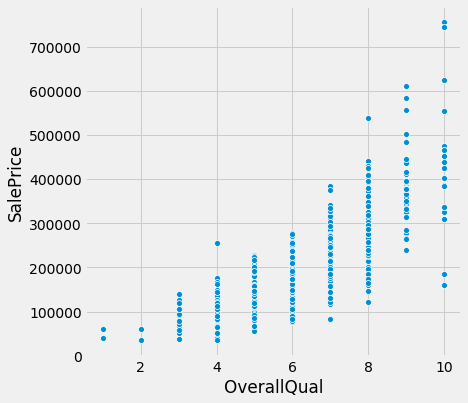

In [15]:
#Scatter Plot
from matplotlib import style

def ScatterPlot(x, y):
    style.use('fivethirtyeight')
    plt.subplots(figsize=(6,6))
    sb.scatterplot(x=x, y=y)
    plt.show();
    
ScatterPlot(df_train.OverallQual, df_train.SalePrice)

OverallQual is a categorical variable

**Heteroscedasticity:** <br>
<li>The relationship between the independent variables and the dependent variable is unequal across all values of the independent variable.
<li> An unequal level of variance across most predictor(independent) variable values and is a red flag for the multiple linear regression model.
<li>We assume that the variability in the response(dependent) variable doesn't increase as the value of the predictor(independent) increases, which is the assumptions of equal variance, also known as Homoscedasticity.
<li>We also assume that the observations are independent of one another(No Multicollinearity).
<li>One way to fix this Heteroscedasticity is by using a transformation method like log-transformation or box-cox transformation.
<br>
    
**Homoscedasticity ( Constant Variance ):**
<li>The relationship between the independent variables and the dependent variable is same across all values of the independent variable. 
<li>In other words, there is a constant variance present in the response variable as the predictor variable increases.
    <li> If the "noise" is not the same across the values of an independent variable like the residual plot above, we call that Heteroscedasticity.
<br>
        <img src=img/Homoscedasticity.jpg>

<br>

**Linearity**<br>
<li>Linear regression needs the relationship between each independent variable and the dependent variable to be linear. The linearity assumption can be tested with scatter plots.

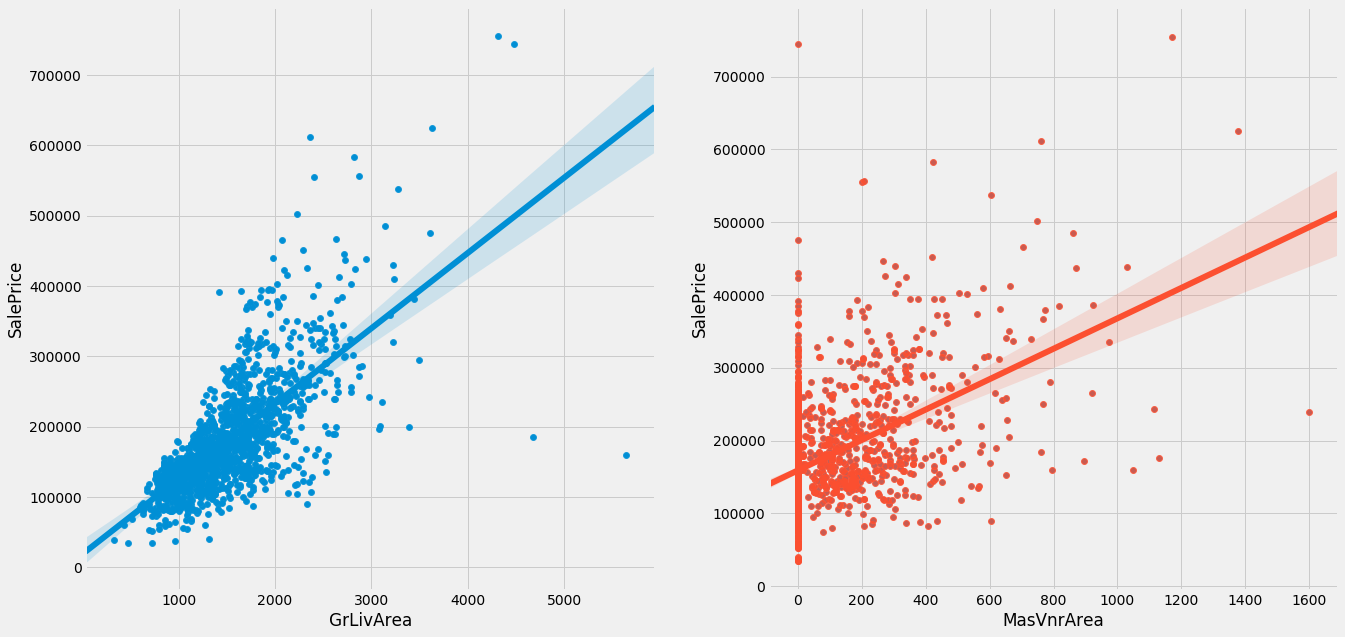

In [16]:
#Creating Subplots

#Defining subplots
fig, (ax1, ax2) = plt.subplots(figsize=(20,10), ncols=2, sharey=False)

#Building first plot
sb.scatterplot(df_train.GrLivArea, df_train.SalePrice, ax=ax1); #graph 1
sb.regplot(df_train.GrLivArea, df_train.SalePrice, ax=ax1); #graph 2

#Building second plot
sb.scatterplot(df_train.MasVnrArea, df_train.SalePrice, ax=ax2)
sb.regplot(df_train.MasVnrArea, df_train.SalePrice, ax=ax2);

**Observation** <br>
<li>It's pretty apparent from the chart that there is a better linear relationship between SalePrice and GrLivArea than SalePrice and MasVnrArea.
<li>Outliers in the dataset.
<li>Linear regression is sensitive to outlier effects.   

**Residual Plot**
<br>
<li>Tells us how is the error variance across the true line. 
<li>The error plot shows that as GrLivArea value increases the variance also increases, which is the characteristics known as Heteroscedasticity

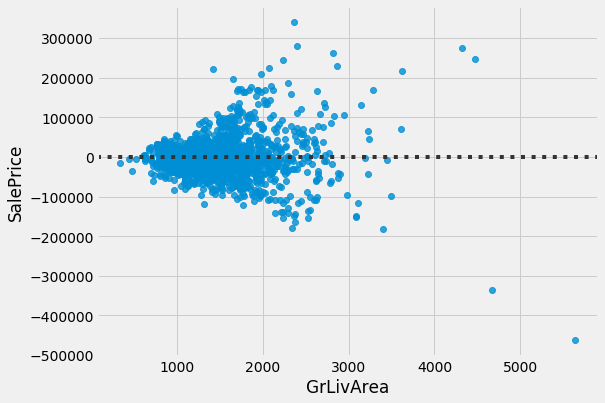

In [17]:
plt.figure(figsize=(8,6))
sb.residplot(df_train.GrLivArea, df_train.SalePrice)
plt.show();

In [78]:
# #Manual Residual Plot
# plt.figure(figsize=(8,8))
# plt.scatter(train_prediction, train_prediction - y_train, c='b', label='Training Prediction')
# plt.scatter(test_prediction, test_prediction - y_test, c='r', label='Test Prediction')
# #plt.hlines(y=0, xmin=10.5, xmax=13.5, color='red' ) #to be adjusted accordingly
# #plt.plot([10.5, 13.5], [10.5, 13.5], c = "red") to demonstrate line not part of original code
# plt.xlabel('Predicted Values')
# plt.ylable('Residuals')
# plt.legend(loc='upper left') 
# plt.show();

<img src='img/residualplot.png'>

**Residual** <br>
The difference between the observed value of the dependent variable (y) and the predicted value (ŷ) is called the residual (e). Each data point has one residual.

Residual = Observed value - Predicted value <br>
e = y - ŷ <br>
**Note:** Both the sum and the mean of the residuals are equal to zero. That is, Σ e = 0 and e = 0.
<br><br>
A residual plot is a graph that shows the residuals on the vertical axis and the independent variable on the horizontal axis. If the points in a residual plot are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data; otherwise, a non-linear model is more appropriate.
<a href='https://stattrek.com/regression/residual-analysis.aspx'>**More...**</a>

**Multivariate Normality ( Normality of Errors):** <br>
<li>The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram or a Q-Q-Plot can check whether the target variable is normally distributed or not. The goodness of fit test.

**No or Little multicollinearity:** <br>
Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:<br><br>
<li>The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.
<li>Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.
<li>With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate. 
<li>We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.<br><br>
Heatmap is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

### Heat Map

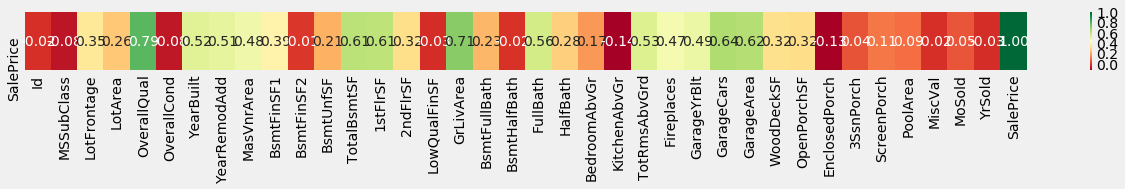

In [18]:
#Correlation Matrix
plt.figure(figsize=(20,1))
sb.heatmap(df_train.corr().sort_values(by='SalePrice').tail(1), cmap='RdYlGn', annot=True, fmt='.2f')
plt.show();

In [19]:
numcorr = df_train.corr()
numcorr['SalePrice'].sort_values(ascending=False).to_frame().T

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,BsmtFinSF2,BsmtHalfBath,MiscVal,Id,LowQualFinSF,YrSold,OverallCond,MSSubClass,EnclosedPorch,KitchenAbvGr
SalePrice,1.0,0.790982,0.708624,0.640409,0.623431,0.613581,0.605852,0.560664,0.533723,0.522897,...,-0.011378,-0.016844,-0.02119,-0.021917,-0.025606,-0.028923,-0.077856,-0.084284,-0.128578,-0.135907


In [20]:
#Correlation with gradient
cm = sb.light_palette('cyan', as_cmap=True)
nc = numcorr['SalePrice'].sort_values(ascending=False).head(15).to_frame()
nc.style.background_gradient(cmap = cm)

,SalePrice
SalePrice,1
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


### Subplots

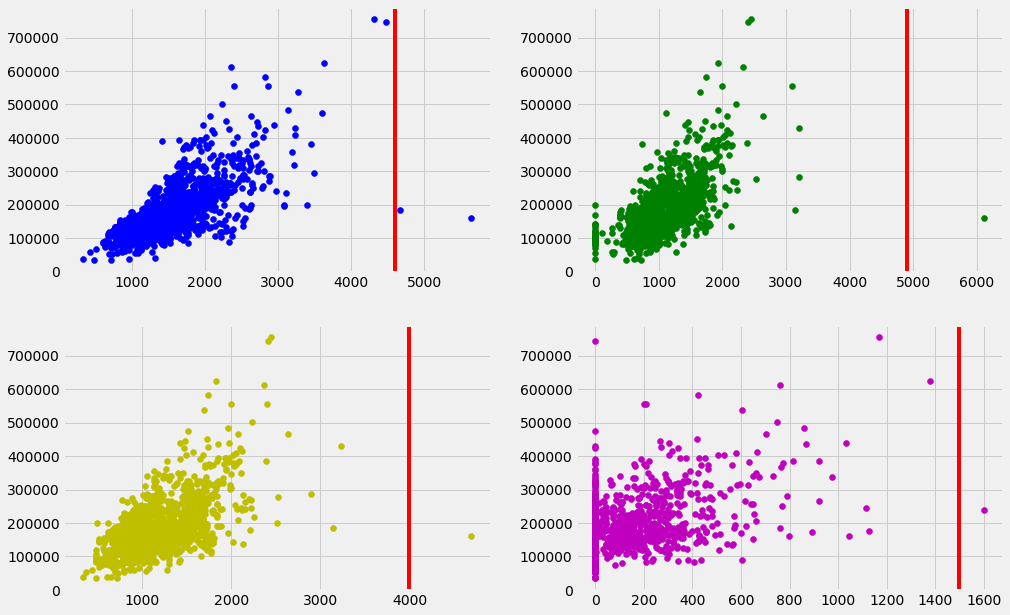

In [21]:
plt.figure(figsize=(15,10))

#Subplot 0,1
plt.subplot2grid((2,2), (0,0))
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c='b')
plt.axvline(x=4600, c='r', linestyle='-')

#Subplot 0,2
plt.subplot2grid((2,2), (0,1))
plt.scatter(df_train.TotalBsmtSF, df_train.SalePrice, c='g')
plt.axvline(x=4900, c='r', linestyle='-')

#subplot(1, 0)
plt.subplot2grid((2,2), (1,0))
plt.scatter(df_train['1stFlrSF'], df_train.SalePrice, c='y')
plt.axvline(x=4000, c='r', linestyle='-')

#subplot(1, 1)
plt.subplot2grid((2,2), (1,1))
plt.scatter(df_train.MasVnrArea, df_train.SalePrice, c='m')
plt.axvline(x=1500, c='r', linestyle='-')

plt.show();

### Skewing Data

In [ ]:
from scipy.stats import boxcox_normmax

def handle_skew(df_temp):
    #Separte the numerical features from dataset as skew only applies to them
    num_feats = df_temp.select_dtypes(exclude='object').columns
    skew_data = df_temp[num_feats].apply(lambda x: skew(x.dropna()))
    more_skewed = skew_data[abs(skew_data)>0.5]
    more_skewed = more_skewed.sort_values(ascending=False)
    print('No. of the features to be treated for skewness:', len(more_skewed.index))
    
    #Fixing skewness
    for col in more_skewed.index:
        df_temp[col] = boxcox1p(df_temp[col], boxcox_normmax(df_temp[col]+1))
        
    return df_temp

handle_skew(df_train)

## Function to find overfit columns

In [24]:
def Find_OverFit_Cols(df_temp):
    overfit_cols = []
    
    for col in df_temp.columns:
        uniqvals = df_temp[col].value_counts()
        cntoffirstval = uniqvals.iloc[0]
        if cntoffirstval/len(df_temp)*100 > 99.94:
            overfit_cols.append(col)
    
    return overfit_cols

Find_OverFit_Cols(df_train_copy)
#Need to drop these columns

[]

## Split Data

In [27]:
# Train Test Split
# x_train, x_test, y_train, y_test = train_test_split(training_data, target, test_size=0.33, random_state=42)

In [ ]:
#Review train and test set size
print('Length of Training Set:', x_train.shape)
print('Length of Test Set:', x_test.shape)

## One Hot Encoding without Dummy Variable Trap

In [ ]:
# #Actual onehot encoding avoiding dummy variable trap
# for col in catg_feats:
#     df_temp = df_alldata[col]
#     df_temp = pd.DataFrame(df_temp)
#     df_temp = pd.get_dummies(df_temp, prefix = col)
#     temp = df_temp.columns[0] #Delete one dummy variable
#     df_temp.drop(temp, inplace=True, axis=1)
#     df_alldata = pd.concat([df_alldata, df_temp], axis=1).reset_index(drop=True)
#     df_alldata.drop(col, inplace=True, axis=1) #Delete actual column from dataframe

In [ ]:
# all_data = pd.get_dummies(all_data, columns = ["Foundation"], prefix="Foundation")
# all_data.head(3)

## Model Building

### Cross Validation Strategy

In [32]:
from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, StratifiedKFold, StratifiedShuffleSplit

#Method1
cross_val = KFold(n_splits=10, shuffle=True, random_state=42)

#Method2
shuf_split = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)

#Method3
# x_train, x_test, y_train, y_test = train_test_split(df_train, y_train, test_size=0.33, random_state=42)

#Method4
strat_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Function to find RMSE for Train and Test set

In [63]:
def rmse_test(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_train(model, X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

### Function for Submission

In [76]:
from datetime import datetime
import os

def Submission(prediction):
    df_pred = pd.DataFrame({'Id':srs_testid, 'SalePrice':prediction})
    print('Sample Prediction:', prediction[:5])
    
    #Defining file name
    tday = datetime.today()
    tm = str(tday.date().day)+str(tday.date().month)+str('_')+str(tday.time().hour)+str(tday.time().minute)+str(tday.time().second)
    fn = 'Submission_'
    fn = str(fn)+str(tm)+str('.csv')
    
    #Saving prediction to csv
    df_pred.to_csv(fn, index=False)
    print('Submission file saved to', os.path.realpath(fn))

### Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
scaler= RobustScaler()
# transform "x_train"
# x_train = scaler.fit_transform(x_train)
# transform "x_test"
# x_test = scaler.transform(x_test)
#Transform the test set
# X_test= scaler.transform(Test)

In [ ]:
#Alpha for Ridge and Lasso
parameters = {'alpha':[x for x in range(1,101)]} #For Ridge
parameters = {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100]} #For Lasso
alphas_ridge = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas_lasso = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
elastic_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
elastic_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
# print("Try again for more precision with alphas centered around " + str(alpha))
# ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
#                           alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
#                           alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],cv = 5)
# ridge.fit(X_train, y_train)
# alpha = ridge.alpha_
# print("Best alpha :", alpha)

### Pipeline

In [ ]:
# ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_ridge, cv=cros_val))
# lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas_lasso, random_state=42, cv=cross_val))
# elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=elastic_alphas, 
#                                                         cv=cross_val, l1_ratio=elastic_l1ratio))                                
# svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

### Ridge

In [29]:
# from sklearn.linear_model import RidgeCV, Ridge

# # regressor = RidgeCV(alphas=parameters, cv=5, random_state=42, n_jobs=-1)
# # regressor.fit(x_train, y_train)
# # print('Best Alpha:', regressor.alpha_)

# #Building actual model
# regressor = Ridge(alpha=regressor.alpha_, random_state=42, max_iter=1000)

# #Train the model
# regressor.fit(x_train, y_train)

# #Predict with model
# pred = regressor.predict(x_test)

### Lasso

In [28]:
from sklearn.linear_model import LassoCV, Lasso, LassoLars
# regressor = LassoCV(alphas=[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100], cv=5, random_state=42, n_jobs=-1)
# regressor.fit(x_train, y_train)
# print('Best Alpha:',regressor.alpha_)

### Plotting Feature Importance Graph

In [ ]:
# #Feature Importance Graph
# model_coef = pd.Series(data = regressor.coef_, index=training_data.columns)
# df_coef = pd.concat([model_coef.sort_values(ascending=False).tail(10), model_coef.sort_values(ascending=False).head(10)])
# plt.figure(figsize=(8, 10))
# df_coef.plot(kind='barh')
# plt.show();

In [ ]:
# #Finding best co-eff
# coef = pd.Serries(model.coef_, index = df_train.columns)
# print('Model picked', str(sum(coef !=0)),'features and to drop', str(sum(coef ==0)),'other Features.')

# #Output: Model picked 280 features and to drop 8 other Features.

### ElasticNet

In [ ]:
from sklearn.linear_model import ElasticNetCV

# #alphas = [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00054255]
# #l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]

# #elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

# #elasticmod = elastic_cv.fit(x_train, y_train.ravel())
# #ela_pred=elasticmod.predict(x_test)
# #print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, ela_pred))))
# #print(elastic_cv.alpha_)

### XGBRegressor

In [ ]:
from xgboost.sklearn import XGBRegressor

#xg_reg = XGBRegressor()
#xgparam_grid= {'learning_rate' : [0.01],'n_estimators':[2000, 3460, 4000],
#                                     'max_depth':[3], 'min_child_weight':[0,3,5],
#                                     'colsample_bytree':[0.5,0.7],
#                                     'reg_alpha':[0.0001,0.001,0.01,0.1,10,100],
#                                    'reg_lambda':[1,0.01,0.8,0.001,0.0001]}
#
#xg_grid=GridSearchCV(xg_reg, param_grid=xgparam_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#xg_grid.fit(x_train,y_train)
#print(xg_grid.best_estimator_)
#print(xg_grid.best_score_)
#print(xg_grid.best_param_)

### Extra Trees Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
ex_reg=ExtraTreesRegressor(n_estimators=2000, max_depth=20)

### Voting Regressor

In [ ]:
from sklearn.ensemble import VotingRegressor

# vote_mod = VotingRegressor([('Ridge', ridge_mod), ('Lasso', lasso_mod), ('Elastic', elastic_cv), ('XGBRegressor', xgb)])
# vote= vote_mod.fit(x_train, y_train.ravel())
# vote_pred=vote.predict(x_test)

### Stacking Regressor <br>
<img src='img/stacking.png'>

In [ ]:
from mlxtend.regressor import StackingRegressor

# stregr = StackingRegressor(regressors=[elastic_cv,ridge_mod, lasso_mod, vote_mod], 
#                            meta_regressor=xgb, use_features_in_secondary=True
#                           )

# stack_mod=stregr.fit(x_train, y_train.ravel())
# stacking_pred=stack_mod.predict(x_test)

# print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, stacking_pred))))

### Gradient Boosting

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)

### Microsoft LightGBMRegressor

In [73]:
from lightgbm import LGBMRegressor
lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

### XGBoost Model

In [75]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [ ]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), 
          LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

---

## Appendix

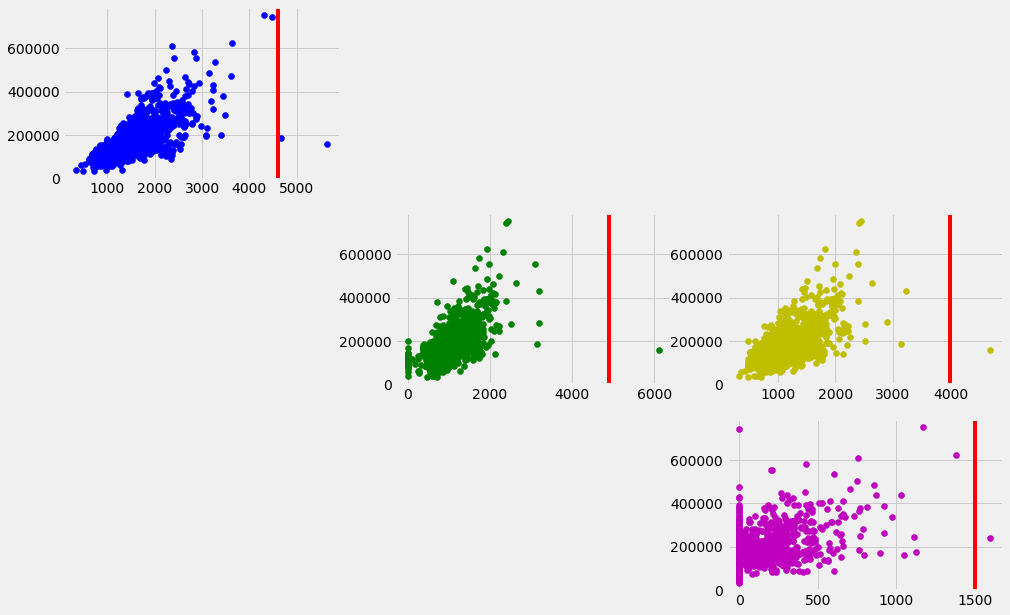

In [22]:
plt.figure(figsize=(15,10))

#Subplot 0,1
plt.subplot2grid((3,3), (0,0))
plt.scatter(df_train.GrLivArea, df_train.SalePrice, c='b')
plt.axvline(x=4600, c='r', linestyle='-')

#Subplot 0,2
plt.subplot2grid((3,3), (1,1))
plt.scatter(df_train.TotalBsmtSF, df_train.SalePrice, c='g')
plt.axvline(x=4900, c='r', linestyle='-')

#subplot(1, 0)
plt.subplot2grid((3,3), (1,2))
plt.scatter(df_train['1stFlrSF'], df_train.SalePrice, c='y')
plt.axvline(x=4000, c='r', linestyle='-')

#subplot(1, 1)
plt.subplot2grid((3,3), (2,2))
plt.scatter(df_train.MasVnrArea, df_train.SalePrice, c='m')
plt.axvline(x=1500, c='r', linestyle='-')

plt.show();